In [105]:
from pathlib import Path
from hloc.utils.io import list_h5_names, get_matches, get_keypoints
from hloc.visualization import plot_images, plot_keypoints, plot_matches, read_image, add_text, cm_RdGn

In [106]:
DIR = "../image-matching-challenge-2023"
MODE = "train"
NAME = "SP+SG"
dataset = "heritage" # "heritage", "haiper", "urban"
scene = "cyprus" # "dioscuri", "cyprus", "wall", "kyiv-puppet-theater", "bike", "chairs", "fountain"

In [107]:
scene_dir = Path(f"../outputs/{NAME}/{dataset}/{scene}")

images = Path(f"{DIR}/{MODE}/{dataset}/{scene}/images")

features = scene_dir / "features.h5"
matches = scene_dir / "matches.h5"

In [108]:
image_names = sorted(list_h5_names(features))
pairs = sorted(list_h5_names(matches))

len(image_names)

30

In [109]:
id0 = 6
id1 = 5

name0 = image_names[id0]
name1 = image_names[id1]

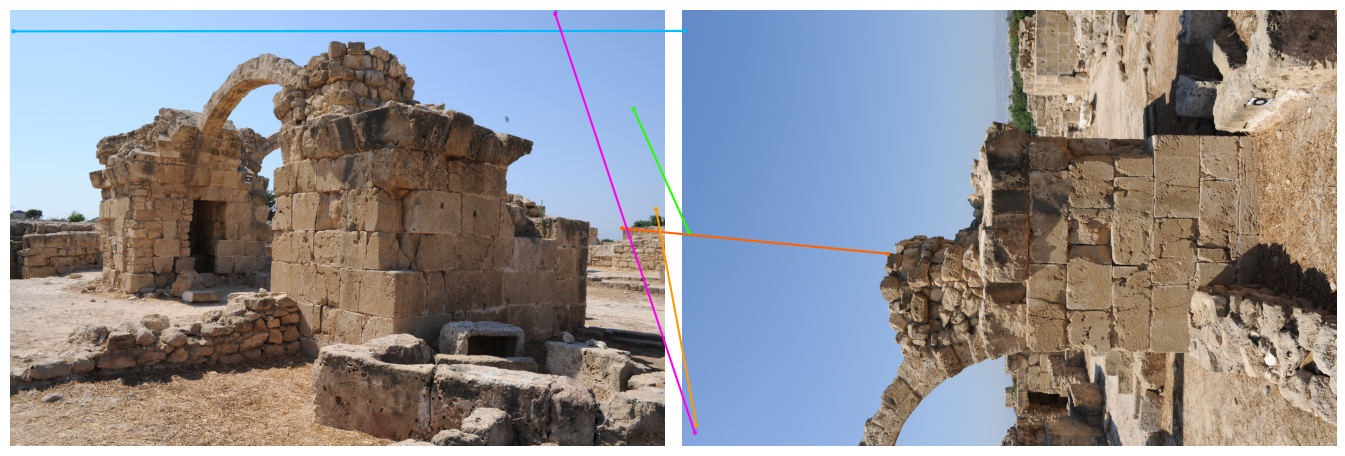

In [110]:
kp0, kp1 = get_keypoints(features, name0), get_keypoints(features, name1)
m, sc = get_matches(matches, name0, name1)

plot_images([read_image(images / name0), read_image(images / name1)])
plot_matches(kp0[m[:,0]], kp1[m[:,1]])

In [111]:
import h5py as h5
feats = h5.File(features, "r")

feats[name0]["keypoints"][:3]

array([[ 965.5, 2364. ],
       [3650. ,  587. ],
       [2168. , 2812. ]], dtype=float16)

In [112]:
m = h5.File(matches, "r")

m[name1][name0]["matches0"][:3]

array([-1, -1, -1], dtype=int16)

# Try to match the rotation of the two images

In [113]:
import collections.abc as collections

import cv2
import numpy as np
import PIL.Image
import torch

from hloc import extractors, matchers

from hloc.utils.base_model import dynamic_load
from hloc.utils.io import read_image

In [114]:
feat_conf = {
    "model": {
        "name": "superpoint",
        "nms_radius": 3,
        "max_keypoints": 4096,
    },
    "preprocessing": {
        "grayscale": True,
        "resize_max": 1600,
        "resize_force": True,
        "interpolation": "cv2_area",
    },
}

match_conf = {
    "output": "matches-superglue",
    "model": {
        "name": "superglue",
        "weights": "outdoor",
        "sinkhorn_iterations": 50,
    }
}

In [115]:
Model = dynamic_load(extractors, feat_conf["model"]["name"])
feat_model = Model(feat_conf["model"]).eval().cpu()

Loaded SuperPoint model


In [116]:
Model = dynamic_load(matchers, match_conf["model"]["name"])
match_model = Model(match_conf["model"]).eval()

Loaded SuperGlue model ("outdoor" weights)


In [117]:
def resize_image(image, size, interp):
    if interp.startswith("cv2_"):
        interp = getattr(cv2, "INTER_" + interp[len("cv2_") :].upper())
        h, w = image.shape[:2]
        if interp == cv2.INTER_AREA and (w < size[0] or h < size[1]):
            interp = cv2.INTER_LINEAR
        resized = cv2.resize(image, size, interpolation=interp)
    elif interp.startswith("pil_"):
        interp = getattr(PIL.Image, interp[len("pil_") :].upper())
        resized = PIL.Image.fromarray(image.astype(np.uint8))
        resized = resized.resize(size, resample=interp)
        resized = np.asarray(resized, dtype=image.dtype)
    else:
        raise ValueError(f"Unknown interpolation {interp}.")
    return resized


def preprocess_image(image, conf):
    image = image.astype(np.float32)
    size = image.shape[:2][::-1]

    if conf["resize_max"] and (max(size) > conf["resize_max"]):
        scale = conf["resize_max"] / max(size)
        size_new = tuple(int(round(x * scale)) for x in size)
        image = resize_image(image, size_new, conf["interpolation"])

    print(image.shape)
    if conf["grayscale"]:
        image = image[None]
    else:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW

    image = image / 255.0

    return {
        "image": torch.tensor(image),
        "original_size": torch.tensor(size),
    }

In [118]:
im0 = read_image(images / name0, grayscale=True)
im1 = read_image(images / name1, grayscale=True)

im0.shape, im1.shape

((4032, 6048), (4032, 6048))

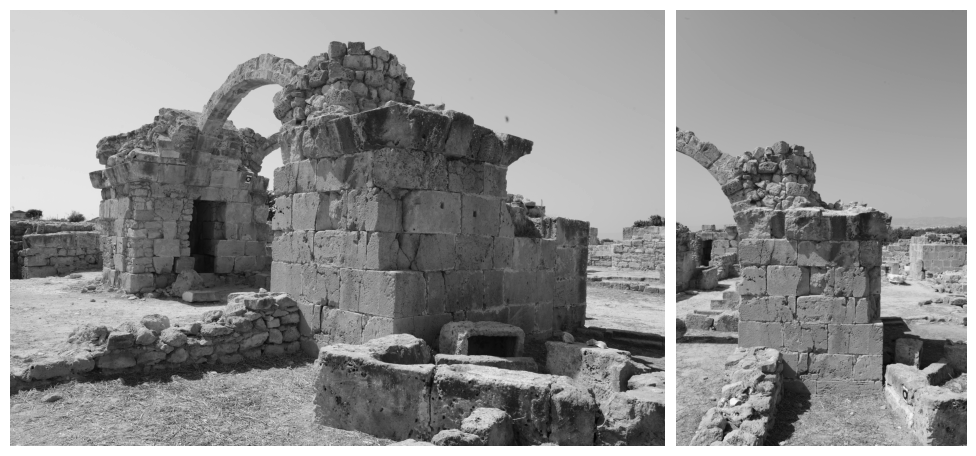

In [119]:
# rotate image 1 by 90 degrees
im1 = np.rot90(im1, 3)


# show imgaes
plot_images([im0, im1])

In [120]:
data0 = preprocess_image(im0, conf=feat_conf["preprocessing"])
data1 = preprocess_image(im1, conf=feat_conf["preprocessing"])

data0["image"].shape

(1067, 1600)
(1600, 1067)


torch.Size([1, 1067, 1600])

In [121]:
def extract_features(model, data):
    with torch.no_grad():
        pred = model({"image": data["image"].to("cpu", non_blocking=True).unsqueeze(0)})
        
    pred = {k: v[0].cpu().numpy() for k, v in pred.items()}
    pred["image_size"] = original_size = data["original_size"].numpy()

    if "keypoints" in pred:
            size = np.array(data["image"].shape[-2:][::-1])
            scales = (original_size / size).astype(np.float32)
            pred["keypoints"] = (pred["keypoints"] + 0.5) * scales[None] - 0.5
            if "scales" in pred:
                pred["scales"] *= scales.mean()
            # add keypoint uncertainties scaled to the original resolution
            uncertainty = getattr(model, "detection_noise", 1) * scales.mean()

    for k in pred:
        dt = pred[k].dtype
        if (dt == np.float32) and (dt != np.float16):
            pred[k] = pred[k].astype(np.float16)

    return pred

kpts0 = extract_features(feat_model, data0)
kpts1 = extract_features(feat_model, data1)

In [122]:
data = {}

for k, v in kpts0.items():
    data[k + "0"] = torch.from_numpy(v.__array__()).float()

data["image0"] = torch.empty((1,) + tuple(kpts0["image_size"])[::-1])

for k, v in kpts1.items():
    data[k + "1"] = torch.from_numpy(v.__array__()).float()

data["image1"] = torch.empty((1,) + tuple(kpts1["image_size"])[::-1])


In [123]:
match_data = {
    k: v if k.startswith("image") else v.to("cpu", non_blocking=True)
    for k, v in data.items()
}

match_data = {
    k: v.unsqueeze(0)
    for k, v in match_data.items()
}

In [124]:
with torch.no_grad():
    pred = match_model(match_data)

In [125]:
m = pred["matches0"][0].numpy()
sc = pred["matching_scores0"][0].numpy()

In [126]:
np.count_nonzero(m != -1) / 2

385.5

In [127]:
idx = np.where(m != -1)[0]
m = np.stack([idx, m[idx]], -1)
sc = sc[idx]

In [128]:
image0 = read_image(images / name0)
image1 = read_image(images / name1)

image0.shape, image1.shape

((4032, 6048, 3), (4032, 6048, 3))

In [129]:
m.shape

(771, 2)

In [ ]:
def rotate_kpts(kpts, im_shape, k):
    kpts = kpts.copy()
    width, height = im_shape

    rot_kpts = np.zeros_like(kpts)
    if k == 1:
        rot_kpts[:,0], rot_kpts[:,1] = height - kpts[:,1], kpts[:,0]
    elif k == 2:
        rot_kpts[:,0], rot_kpts[:,1] = width - kpts[:,0], height - kpts[:,1]
    elif k == 3:
        rot_kpts[:,0], rot_kpts[:,1] = kpts[:,1], width - kpts[:,0]
    elif k == 0:
        rot_kpts = kpts
    else:
        raise ValueError(f"Unknown rotation {k}")
    
    return rot_kpts

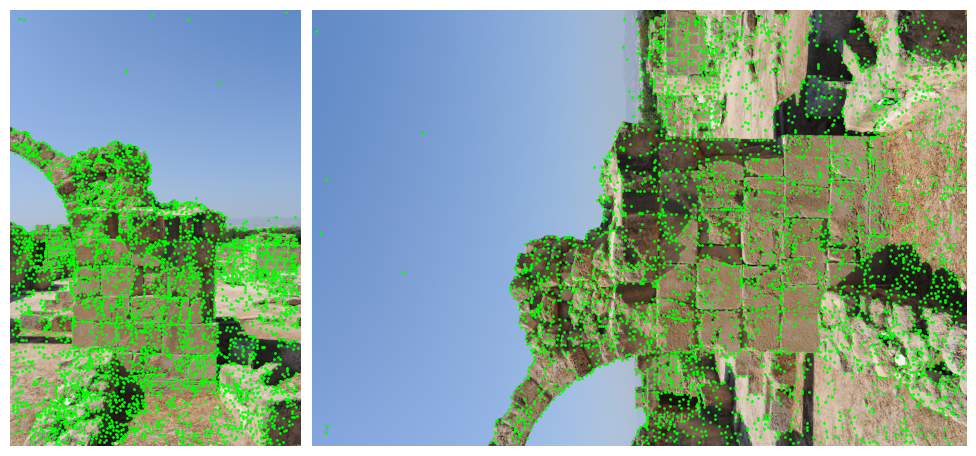

In [135]:
plot_images([np.rot90(image1, k=3), image1])
plot_keypoints([kpts1["keypoints"], rotate_kpts(kpts1["keypoints"], image1.shape[:2], 3)])

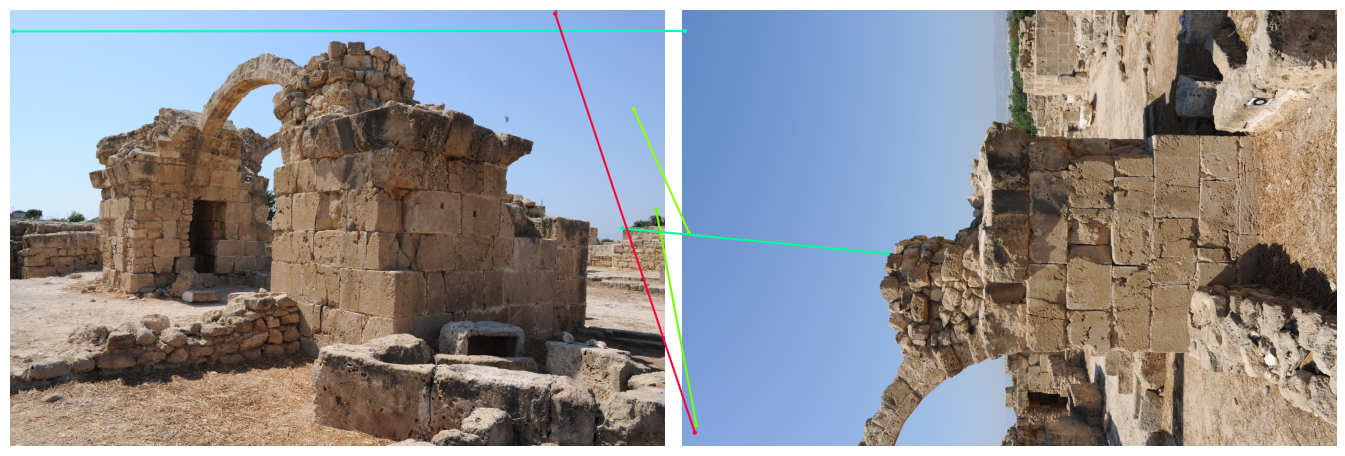

In [131]:
kp0, kp1 = get_keypoints(features, name0), get_keypoints(features, name1)
m_non_rot, sc_non_rot = get_matches(matches, name0, name1)

plot_images([image0, image1])
plot_matches(kp0[m_non_rot[:,0]], kp1[m_non_rot[:,1]])

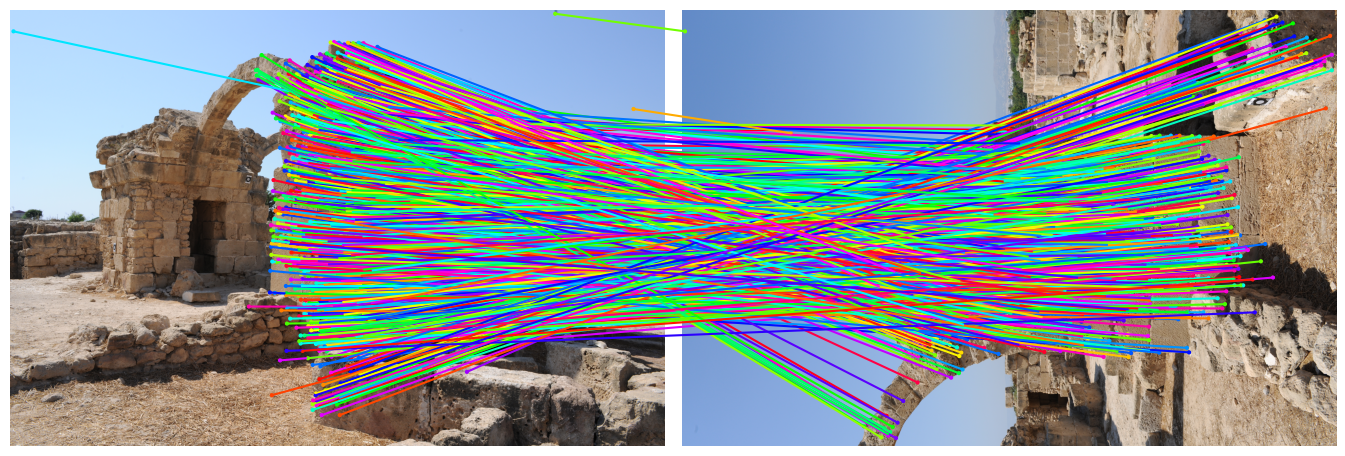

In [133]:
kpt0 = kpts0["keypoints"]
kpt1 = kpts1["keypoints"]

kpt1 = rotate_kpts(kpt1, image1.shape[:2], k=3)

plot_images([image0, np.rot90(image1, k=0)])
# plot_keypoints([kpt0, kpt1])
plot_matches(kpt0[m[:,0]], kpt1[m[:,1]])